## Single Shot Detector for ExtremeWeather Data

### Preprocessing the Data
The [ExtremeWeather](https://extremeweatherdataset.github.io/) data set consists of weather data for a specific 25km region from 1979 to 2005. 
The data is organized by year and contains 4 images per day. Each image has 768x1152 pixels across 16 channels for different weather variables. 
In addition, each day has up to 15 bounding boxes
surrounding extreme weather events classified as Tropical Depression, Tropical Cyclone, Extratropical Cyclone, and Atmospheric River.

The goal is to correctly identify and classify extreme weather events. 
The first challenge is the sheer size of the data set.
Each year, even when compressed, takes 64 GB to store.
As the "small" data set, we consider training on 1979 and 1981 then testing on 1984.
We preprocess each year by considering only the month of July and rescaling each image so its of size 300x300.
In addition, we choose 3 of the 16 channels by hand for 'visual explainability' of bounding boxes.
All together, we are able to reduce the size of the compressed data from 64 GB to 4 MB consisting of 124 300x300 images and bounding boxes.




### Set up

In [1]:
## Load data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Set up
### Loading Data
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

### Visualization
from matplotlib import patches
import matplotlib.pyplot as plt

### Loss function
import itertools
import math
import torch.nn.functional as F
import torch.nn as nn

### Model
import numpy as np
import torch
import gc
import torch.nn as nn
from torch.autograd import Variable

### Training
import time


#### Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")



### Loading the Data

In [3]:
# Modified from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class ExtremeWeatherDataset(Dataset):
  def __init__(self, dir):
    self.bboxes = []
    self.labels = []
    with open(os.path.join(dir, 'bboxes.txt')) as f:
      for line in f:
        self.bboxes += [torch.Tensor(eval(line))]
    with open(os.path.join(dir, 'labels.txt')) as f:
      for line in f:
        self.labels += [torch.Tensor(eval(line))]
    self.dir = dir


  def __len__(self):
    return len(self.bboxes)

  def __getitem__(self, idx):
    img_path = os.path.join(self.dir, str(idx)+'.jpg')
    image = read_image(img_path)
    bbox = self.bboxes[idx]
    label = self.labels[idx]
    return [image/255, bbox, label]

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

prefix = '/content/drive/My Drive/extremeweather/' # where the data is stored
train_data = ExtremeWeatherDataset(dir=prefix+'train/')
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)

### Visualizing Images

In [5]:
EVENTS = ['Tropical Depression', 'Tropical Cyclone', 'Extratropical Cyclone', 'Atmospheric River']
NAMES = ['Sea Level Pressure', 'Total Water', 'Lowest Zonal Wind']
COLORS = ['red', 'blue', 'white', 'black']

def plot_image(image, box, labels):
  if len(image.shape) == 2: image = np.array([image])
  num_channels = image.shape[0]
  num_rows = int(np.sqrt(num_channels))
  num_cols = int(np.round(num_channels//num_rows))
  fig, axs = plt.subplots(num_rows,num_cols, figsize=(15,15)) 
  fig.tight_layout()
  for i in range(num_rows):
    for j in range(num_cols):
      channel = i*num_cols + j 
      if channel < image.shape[0]:
        if num_channels == 1: ax = axs
        elif num_rows == 1: ax = axs[j]
        elif num_rows > 1: ax = axs[i,j]
        ax.axis('off')
        ax.imshow(image[channel,]) 
        addbox(ax, box, labels)
        ax.set_title(NAMES[channel])
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()
    
def addbox(ax, box, labels):
  for i in range(len(box)):
    left, bottom, right, top = box[i]
    handles, existing_labels = ax.get_legend_handles_labels()
    label = "" if (labels == None) or (EVENTS[int(labels[i])] in existing_labels) else EVENTS[int(labels[i])]
    ax.add_patch(patches.Rectangle(xy=(left, bottom), width=right-left,
                                    height=top-bottom, fill=False,
                                    label=label, color=COLORS[int(labels[i])]))



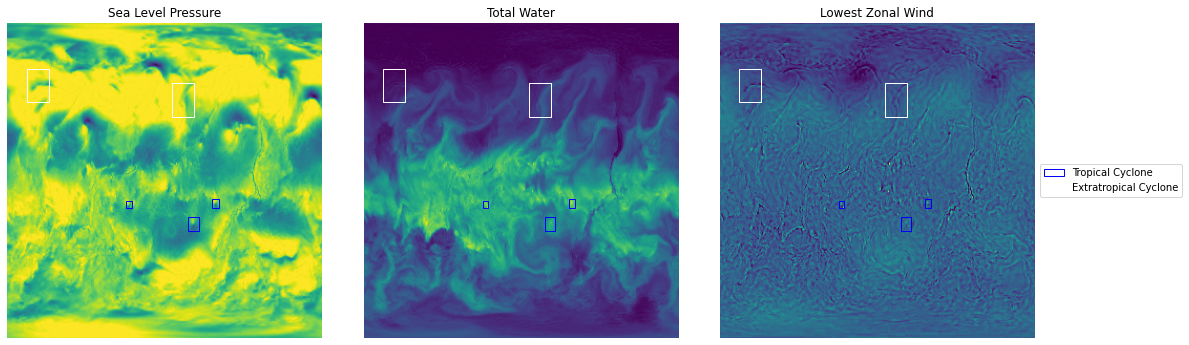

In [6]:
# Plot images
images, bboxes, labels = next(iter(train_dataloader))
plot_image(images[0], bboxes[0], labels[0])

### Box Encoder

In [7]:
# https://github.com/kuangliu/torchcv/blob/master/torchcv/utils/meshgrid.py

def meshgrid(x, y, row_major=True):
    '''Return meshgrid in range x & y.
    Args:
      x: (int) first dim range.
      y: (int) second dim range.
      row_major: (bool) row major or column major.
    Returns:
      (tensor) meshgrid, sized [x*y,2]
    '''
    a = torch.arange(0,x)
    b = torch.arange(0,y)
    xx = a.repeat(y).view(-1,1)
    yy = b.view(-1,1).repeat(1,x).view(-1,1)
    return torch.cat([xx,yy],1) if row_major else torch.cat([yy,xx],1)

# https://github.com/kuangliu/torchcv/blob/master/torchcv/utils/box.py
def change_box_order(boxes, order):
    '''Change box order between (xmin,ymin,xmax,ymax) and (xcenter,ycenter,width,height).
    Args:
      boxes: (tensor) bounding boxes, sized [N,4].
      order: (str) either 'xyxy2xywh' or 'xywh2xyxy'.
    Returns:
      (tensor) converted bounding boxes, sized [N,4].
    '''
    assert order in ['xyxy2xywh','xywh2xyxy']
    a = boxes[:,:2]
    b = boxes[:,2:]
    if order == 'xyxy2xywh':
        return torch.cat([(a+b)/2,b-a], 1)
    return torch.cat([a-b/2,a+b/2], 1)

def box_clamp(boxes, xmin, ymin, xmax, ymax):
    '''Clamp boxes.
    Args:
      boxes: (tensor) bounding boxes of (xmin,ymin,xmax,ymax), sized [N,4].
      xmin: (number) min value of x.
      ymin: (number) min value of y.
      xmax: (number) max value of x.
      ymax: (number) max value of y.
    Returns:
      (tensor) clamped boxes.
    '''
    boxes[:,0].clamp_(min=xmin, max=xmax)
    boxes[:,1].clamp_(min=ymin, max=ymax)
    boxes[:,2].clamp_(min=xmin, max=xmax)
    boxes[:,3].clamp_(min=ymin, max=ymax)
    return boxes

def box_select(boxes, xmin, ymin, xmax, ymax):
    '''Select boxes in range (xmin,ymin,xmax,ymax).
    Args:
      boxes: (tensor) bounding boxes of (xmin,ymin,xmax,ymax), sized [N,4].
      xmin: (number) min value of x.
      ymin: (number) min value of y.
      xmax: (number) max value of x.
      ymax: (number) max value of y.
    Returns:
      (tensor) selected boxes, sized [M,4].
      (tensor) selected mask, sized [N,].
    '''
    mask = (boxes[:,0]>=xmin) & (boxes[:,1]>=ymin) \
         & (boxes[:,2]<=xmax) & (boxes[:,3]<=ymax)
    boxes = boxes[mask,:]
    return boxes, mask

def box_iou(box1, box2):
    '''Compute the intersection over union of two set of boxes.
    The box order must be (xmin, ymin, xmax, ymax).
    Args:
      box1: (tensor) bounding boxes, sized [N,4].
      box2: (tensor) bounding boxes, sized [M,4].
    Return:
      (tensor) iou, sized [N,M].
    Reference:
      https://github.com/chainer/chainercv/blob/master/chainercv/utils/bbox/bbox_iou.py
    '''
    N = box1.size(0)
    M = box2.size(0)

    lt = torch.max(box1[:,None,:2], box2[:,:2])  # [N,M,2]
    rb = torch.min(box1[:,None,2:], box2[:,2:])  # [N,M,2]

    wh = (rb-lt).clamp(min=0)      # [N,M,2]
    inter = wh[:,:,0] * wh[:,:,1]  # [N,M]

    area1 = (box1[:,2]-box1[:,0]) * (box1[:,3]-box1[:,1])  # [N,]
    area2 = (box2[:,2]-box2[:,0]) * (box2[:,3]-box2[:,1])  # [M,]
    iou = inter / (area1[:,None] + area2 - inter)
    return iou

def box_nms(bboxes, scores, threshold=0.5):
    '''Non maximum suppression.
    Args:
      bboxes: (tensor) bounding boxes, sized [N,4].
      scores: (tensor) confidence scores, sized [N,].
      threshold: (float) overlap threshold.
    Returns:
      keep: (tensor) selected indices.
    Reference:
      https://github.com/rbgirshick/py-faster-rcnn/blob/master/lib/nms/py_cpu_nms.py
    '''
    x1 = bboxes[:,0]
    y1 = bboxes[:,1]
    x2 = bboxes[:,2]
    y2 = bboxes[:,3]

    areas = (x2-x1) * (y2-y1)
    _, order = scores.sort(0, descending=True)

    keep = []
    while order.numel() > 0:
        i = order[0]
        keep.append(i)

        if order.numel() == 1:
            break

        xx1 = x1[order[1:]].clamp(min=x1[i].item())
        yy1 = y1[order[1:]].clamp(min=y1[i].item())
        xx2 = x2[order[1:]].clamp(max=x2[i].item())
        yy2 = y2[order[1:]].clamp(max=y2[i].item())

        w = (xx2-xx1).clamp(min=0)
        h = (yy2-yy1).clamp(min=0)
        inter = w * h

        overlap = inter / (areas[i] + areas[order[1:]] - inter)
        ids = (overlap<=threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids+1]
    return torch.tensor(keep, dtype=torch.long) 

# https://github.com/kuangliu/torchcv/blob/master/torchcv/models/ssd/box_coder.py
class SSDBoxCoder:
    def __init__(self, ssd_model):
        self.steps = ssd_model.steps
        self.box_sizes = ssd_model.box_sizes
        self.aspect_ratios = ssd_model.aspect_ratios
        self.fm_sizes = ssd_model.fm_sizes
        self.default_boxes = self._get_default_boxes()

    def _get_default_boxes(self):
        boxes = []
        for i, fm_size in enumerate(self.fm_sizes):
            for h, w in itertools.product(range(fm_size), repeat=2):
                cx = (w + 0.5) * self.steps[i]
                cy = (h + 0.5) * self.steps[i]

                s = self.box_sizes[i]
                boxes.append((cx, cy, s, s))

                s = math.sqrt(self.box_sizes[i] * self.box_sizes[i+1])
                boxes.append((cx, cy, s, s))

                s = self.box_sizes[i]
                for ar in self.aspect_ratios[i]:
                    boxes.append((cx, cy, s * math.sqrt(ar), s / math.sqrt(ar)))
                    boxes.append((cx, cy, s / math.sqrt(ar), s * math.sqrt(ar)))
        return torch.Tensor(boxes)  # xywh

    def encode(self, boxes, labels):
        '''Encode target bounding boxes and class labels.
        SSD coding rules:
          tx = (x - anchor_x) / (variance[0]*anchor_w)
          ty = (y - anchor_y) / (variance[0]*anchor_h)
          tw = log(w / anchor_w) / variance[1]
          th = log(h / anchor_h) / variance[1]
        Args:
          boxes: (tensor) bounding boxes of (xmin,ymin,xmax,ymax), sized [#obj, 4].
          labels: (tensor) object class labels, sized [#obj,].
        Returns:
          loc_targets: (tensor) encoded bounding boxes, sized [#anchors,4].
          cls_targets: (tensor) encoded class labels, sized [#anchors,].
        Reference:
          https://github.com/chainer/chainercv/blob/master/chainercv/links/model/ssd/multibox_coder.py
        '''
        def argmax(x):
            v, i = x.max(0)
            j = v.max(0)[1].item()
            return (i[j], j)

        default_boxes = self.default_boxes  # xywh
        default_boxes = change_box_order(default_boxes, 'xywh2xyxy')

        ious = box_iou(default_boxes, boxes)  # [#anchors, #obj]
        index = torch.LongTensor(len(default_boxes)).fill_(-1)
        masked_ious = ious.clone()
        while True:
            i, j = argmax(masked_ious)
            if masked_ious[i,j] < 1e-6:
                break
            index[i] = j
            masked_ious[i,:] = 0
            masked_ious[:,j] = 0

        mask = (index<0) & (ious.max(1)[0]>=0.5)
        if mask.any():
            index[mask] = ious[mask.nonzero().squeeze()].max(1)[1]

        boxes = boxes[index.clamp(min=0)]  # negative index not supported
        boxes = change_box_order(boxes, 'xyxy2xywh')
        default_boxes = change_box_order(default_boxes, 'xyxy2xywh')

        variances = (0.1, 0.2)
        loc_xy = (boxes[:,:2]-default_boxes[:,:2]) / default_boxes[:,2:] / variances[0]
        loc_wh = torch.log(boxes[:,2:]/default_boxes[:,2:]) / variances[1]
        loc_targets = torch.cat([loc_xy,loc_wh], 1)
        cls_targets = 1 + labels[index.clamp(min=0)]
        cls_targets[index<0] = 0
        return loc_targets, cls_targets

    def decode(self, loc_preds, cls_preds, score_thresh=0.6, nms_thresh=0.45):
        '''Decode predicted loc/cls back to real box locations and class labels.
        Args:
          loc_preds: (tensor) predicted loc, sized [8732,4].
          cls_preds: (tensor) predicted conf, sized [8732,21].
          score_thresh: (float) threshold for object confidence score.
          nms_thresh: (float) threshold for box nms.
        Returns:
          boxes: (tensor) bbox locations, sized [#obj,4].
          labels: (tensor) class labels, sized [#obj,].
        '''
        variances = (0.1, 0.2)
        xy = loc_preds[:,:2] * variances[0] * self.default_boxes[:,2:] + self.default_boxes[:,:2]
        wh = torch.exp(loc_preds[:,2:]*variances[1]) * self.default_boxes[:,2:]
        box_preds = torch.cat([xy-wh/2, xy+wh/2], 1)

        boxes = []
        labels = []
        scores = []
        num_classes = cls_preds.size(1)
        for i in range(num_classes-1):
            score = cls_preds[:,i+1]  # class i corresponds to (i+1) column
            mask = score > score_thresh
            if not mask.any():
                continue
            box = box_preds[mask.nonzero().squeeze()]
            score = score[mask]

            keep = box_nms(box, score, nms_thresh)
            boxes.append(box[keep])
            labels.append(torch.LongTensor(len(box[keep])).fill_(i))
            scores.append(score[keep])

        boxes = torch.cat(boxes, 0)
        labels = torch.cat(labels, 0)
        scores = torch.cat(scores, 0)
        return boxes, labels, scores

### Loss Function

In [32]:
# https://github.com/kuangliu/torchcv/blob/master/torchcv/loss/ssd_loss.py

class SSDLoss(nn.Module):
    def __init__(self, num_classes):
        super(SSDLoss, self).__init__()
        self.num_classes = num_classes

    def _hard_negative_mining(self, cls_loss, pos):
        '''Return negative indices that is 3x the number as postive indices.
        Args:
          cls_loss: (tensor) cross entroy loss between cls_preds and cls_targets, sized [N,#anchors].
          pos: (tensor) positive class mask, sized [N,#anchors].
        Return:
          (tensor) negative indices, sized [N,#anchors].
        '''
        cls_loss = cls_loss * (pos.float() - 1)

        _, idx = cls_loss.sort(1)  # sort by negative losses
        _, rank = idx.sort(1)      # [N,#anchors]

        num_neg = 3*pos.sum(1)  # [N,]
        neg = rank < num_neg[:,None]   # [N,#anchors]
        return neg

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        '''Compute loss between (loc_preds, loc_targets) and (cls_preds, cls_targets).
        Args:
          loc_preds: (tensor) predicted locations, sized [N, #anchors, 4].
          loc_targets: (tensor) encoded target locations, sized [N, #anchors, 4].
          cls_preds: (tensor) predicted class confidences, sized [N, #anchors, #classes].
          cls_targets: (tensor) encoded target labels, sized [N, #anchors].
        loss:
          (tensor) loss = SmoothL1Loss(loc_preds, loc_targets) + CrossEntropyLoss(cls_preds, cls_targets).
        '''
        pos = cls_targets > 0  # [N,#anchors]
        batch_size = pos.size(0)
        num_pos = pos.sum().item()

        #===============================================================
        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        #===============================================================
        mask = pos.unsqueeze(2).expand_as(loc_preds)       # [N,#anchors,4]
        loc_loss = F.smooth_l1_loss(loc_preds[mask], loc_targets[mask], reduction='sum')

        #===============================================================
        # cls_loss = CrossEntropyLoss(cls_preds, cls_targets)
        #===============================================================
        cls_loss = F.cross_entropy(cls_preds.view(-1,self.num_classes), \
                                   cls_targets.view(-1), reduction='none')  # [N*#anchors,]
        cls_loss = cls_loss.view(batch_size, -1)
        cls_loss[cls_targets<0] = 0  # set ignored loss to 0
        neg = self._hard_negative_mining(cls_loss, pos)  # [N,#anchors]
        cls_loss = cls_loss[pos|neg].sum()

        #print('loc_loss: %.3f | cls_loss: %.3f' % (loc_loss.item()/num_pos, cls_loss.item()/num_pos), end=' | ')
        loss = (loc_loss+cls_loss)/num_pos
        return loss

### Model

In [9]:
# https://github.com/kuangliu/torchcv/blob/master/torchcv/models/ssd/net.py
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layers = self._make_layers()

    def forward(self, x):
        y = self.layers(x)
        return y

    def _make_layers(self):
        '''VGG16 layers.'''
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(True)]
                in_channels = x
        return nn.Sequential(*layers)


class L2Norm(nn.Module):
    '''L2Norm layer across all channels.'''
    def __init__(self, in_features, scale):
        super(L2Norm, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features))
        self.reset_parameters(scale)

    def reset_parameters(self, scale):
        nn.init.constant(self.weight, scale)

    def forward(self, x):
        x = F.normalize(x, dim=1)
        scale = self.weight[None,:,None,None]
        return scale * x


class VGG16Extractor300(nn.Module):
    def __init__(self):
        super(VGG16Extractor300, self).__init__()

        self.features = VGG16()
        self.norm4 = L2Norm(512, 20)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1, dilation=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1, dilation=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1, dilation=1)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3)

    def forward(self, x):
        hs = []
        h = self.features(x)
        hs.append(self.norm4(h))  # conv4_3

        h = F.max_pool2d(h, kernel_size=2, stride=2, ceil_mode=True)

        h = F.relu(self.conv5_1(h))
        h = F.relu(self.conv5_2(h))
        h = F.relu(self.conv5_3(h))
        h = F.max_pool2d(h, kernel_size=3, stride=1, padding=1, ceil_mode=True)

        h = F.relu(self.conv6(h))
        h = F.relu(self.conv7(h))
        hs.append(h)  # conv7

        h = F.relu(self.conv8_1(h))
        h = F.relu(self.conv8_2(h))
        hs.append(h)  # conv8_2

        h = F.relu(self.conv9_1(h))
        h = F.relu(self.conv9_2(h))
        hs.append(h)  # conv9_2

        h = F.relu(self.conv10_1(h))
        h = F.relu(self.conv10_2(h))
        hs.append(h)  # conv10_2

        h = F.relu(self.conv11_1(h))
        h = F.relu(self.conv11_2(h))
        hs.append(h)  # conv11_2
        return hs


class SSD300(nn.Module):
    steps = (8, 16, 32, 64, 100, 300)
    box_sizes = (30, 60, 111, 162, 213, 264, 315)  # default bounding box sizes for each feature map.
    aspect_ratios = ((2,), (2,3), (2,3), (2,3), (2,), (2,))
    fm_sizes = (38, 19, 10, 5, 3, 1)

    def __init__(self, num_classes):
        super(SSD300, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = (4, 6, 6, 6, 4, 4)
        self.in_channels = (512, 1024, 512, 256, 256, 256)

        self.extractor = VGG16Extractor300()
        self.loc_layers = nn.ModuleList()
        self.cls_layers = nn.ModuleList()
        for i in range(len(self.in_channels)):
        	self.loc_layers += [nn.Conv2d(self.in_channels[i], self.num_anchors[i]*4, kernel_size=3, padding=1)]
        	self.cls_layers += [nn.Conv2d(self.in_channels[i], self.num_anchors[i]*self.num_classes, kernel_size=3, padding=1)]

    def forward(self, x):
        loc_preds = []
        cls_preds = []
        xs = self.extractor(x)
        for i, x in enumerate(xs):
            loc_pred = self.loc_layers[i](x)
            loc_pred = loc_pred.permute(0,2,3,1).contiguous()
            loc_preds.append(loc_pred.view(loc_pred.size(0),-1,4))

            cls_pred = self.cls_layers[i](x)
            cls_pred = cls_pred.permute(0,2,3,1).contiguous()
            cls_preds.append(cls_pred.view(cls_pred.size(0),-1,self.num_classes))

        loc_preds = torch.cat(loc_preds, 1)
        cls_preds = torch.cat(cls_preds, 1)
        return loc_preds, cls_preds

### Training!

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 5
model = SSD300(num_classes)
model.to(device)

In [33]:
optimizer = torch.optim.Adam(model.parameters())
criterion = SSDLoss(num_classes)
box_coder = SSDBoxCoder(model)

In [11]:
### Helper functions
def clear_ram():
  gc.collect()
  torch.cuda.empty_cache()
  with torch.no_grad():
    torch.cuda.empty_cache()

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [40]:
def train(model, iterator, optimizer, criterion, box_coder):
  model.train()
  epoch_loss = 0

  for images, bboxes, labels in iterator:
    clear_ram()
    
    images = torch.stack(images).to(device)
    loc_targets, cls_targets = zip(*[box_coder.encode(bbox, label) for bbox, label in zip(bboxes, labels)])
    loc_targets = torch.stack(loc_targets).long().to(device)
    cls_targets = torch.stack(cls_targets).long().to(device)

    optimizer.zero_grad()
    loc_preds, cls_preds = model(images)
    loss = criterion(loc_preds, loc_targets, cls_preds, cls_targets)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    del loc_preds, cls_preds
  
  return epoch_loss / len(iterator)

In [39]:
def evaluate(model, iterator, criterion, box_coder):
  model.eval()
  epoch_loss = 0

  with torch.no_grad():
    for images, bboxes, labels in iterator:
      clear_ram()

      images = torch.stack(images).to(device)
      loc_targets, cls_targets = zip(*[box_coder(bbox, label) for bbox, label in zip(bboxes, labels)])
      loc_targets = torch.stack(loc_targets).long().to(device)
      cls_targets = torch.stack(cls_targets).long().to(device)
  
      loc_preds, cls_preds = model(images)
      loss = criterion(loc_preds, loc_targets, cls_preds, cls_targets)

      epoch_loss += loss.item()

      del loc_preds, cls_preds
    
  return epoch_loss / len(iterator)

In [42]:
train_loss = []

In [41]:
n_epochs = 3

best_loss = float('inf')

for epoch in range(n_epochs):
  start = time.time()
  train_loss += [train(model, train_dataloader, optimizer, criterion, box_coder)]
  #val_loss = evaluate(model, valid_dataloader, criterion, box_coder)

  epoch_mins, epoch_secs = epoch_time(start, time.time())

  eval_loss = train_loss[-1]
  if eval_loss < best_loss:
    best_loss = eval_loss
    torch.save(model.state_dict(), 'model.pt')

  print(f'\nEpoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s', end =' ')
  print(f'| Train Loss: {train_loss[-1]:.3f}')
  #print(f'| Valid Loss: {valid_loss:.3f}', sep=' | )


Epoch: 01 | Epoch Time: 0m 14s | Train Loss: 5.331

Epoch: 02 | Epoch Time: 0m 13s | Train Loss: 5.253

Epoch: 03 | Epoch Time: 0m 13s | Train Loss: 5.302


In [ ]:
#model.load_state_dict(torch.load('model.pt'))
#test_loss = evaluate(model, test_dataloader, criterion)
#print(f'\t Test Loss: {test_loss:.3f}'